# Xarray with Dask
This tutorial demonstrates how we can use Xarrays with Dask.

Learning outcomes of the tutorial are:
1. Learn the basics of Xarray.
2. Learn how to use Xarrays with Dask.
3. Learn how to scale Xarray on Dask

Prerequisite:
1. Experience with Dask High-level objects 

![](figs/xarray.png)
Xarray extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It shares a similar API to NumPy and Pandas and supports both Dask and NumPy arrays under the hood.

In [1]:
# set the path 
import os
user = os.getenv('USER', 'default value')
path = '/scratch/vp91/'+user
print(path)

/scratch/vp91/jxj900


In [2]:
# The jupyter notebook is launched from your $HOME directory.
# Change the working directory the user directory under /scratch/vp91
os.chdir(os.path.expandvars(path))

## Xarray basic

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

In Xarray a labeled, N-dimensional array is called 
<span style="color:deepskyblue"> **DataArray**</span>. <span style="color:deepskyblue"> **Dimensions**</span>  provide names that xarray uses instead of the axis argument found in many numpy functions.  <span style="color:deepskyblue"> **Coordinates**</span> enable fast label based indexing and alignment. This is similar to functionality of the index found on a pandas DataFrame.

In [3]:
data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [4]:
data.dims

('x', 'y')

In [5]:
data.coords

Coordinates:
  * x        (x) int64 10 20

### Indexing in Xarray
Indexing is pissoble in Xarray using multiple methods.

Positional and by integer label, like numpy

In [6]:
data[0, :]

<xarray.DataArray (y: 3)>
array([-0.19801384,  0.646081  , -0.07566074])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

loc or "location": positional and coordinate label, like pandas

In [7]:
data.loc[10]

<xarray.DataArray (y: 3)>
array([-0.19801384,  0.646081  , -0.07566074])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

isel or "integer select":  by dimension name and integer label


In [8]:
data.isel(x=0)

<xarray.DataArray (y: 3)>
array([-0.19801384,  0.646081  , -0.07566074])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

sel or "select": by dimension name and coordinate label

In [9]:
data.sel(x=10)

<xarray.DataArray (y: 3)>
array([-0.19801384,  0.646081  , -0.07566074])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

Label-based indexing is particularly usesful as we dont need to know how our array is organized. All we need to know are the dimension name and the label we wish to index. **data.sel(x=10)**,  works regardless of whether x is the first or second dimension of the array and regardless of whether 10 is the first or the second element of x. 

Xarray works similar to Numpy arrays with the additional option of using labels.

In [10]:
mean = data.mean(dim="x")
mean

<xarray.DataArray (y: 3)>
array([-0.19526199,  0.57276854,  1.0323616 ])
Dimensions without coordinates: y

In [11]:
a = xr.DataArray(np.random.randn(3), [data.coords["y"]])
a

<xarray.DataArray (y: 3)>
array([ 0.1192611 , -0.07903033,  1.37564581])
Coordinates:
  * y        (y) int64 0 1 2

In [12]:
b = xr.DataArray(np.random.randn(4), dims="z")
b

<xarray.DataArray (z: 4)>
array([-1.63163044, -0.6595196 , -2.27053212,  0.42694029])
Dimensions without coordinates: z

Another advantage of Xarray is that arithmetic operations broadcast is possible for DataArray of different dimension.

In [13]:
a + b

<xarray.DataArray (y: 3, z: 4)>
array([[-1.51236934, -0.5402585 , -2.15127102,  0.54620139],
       [-1.71066077, -0.73854993, -2.34956245,  0.34790996],
       [-0.25598463,  0.71612621, -0.89488631,  1.8025861 ]])
Coordinates:
  * y        (y) int64 0 1 2
Dimensions without coordinates: z

In [14]:
data

<xarray.DataArray (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [15]:
data.T

<xarray.DataArray (y: 3, x: 2)>
array([[-0.19801384, -0.19251015],
       [ 0.646081  ,  0.49945609],
       [-0.07566074,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [16]:
data - data.T

<xarray.DataArray (x: 2, y: 3)>
array([[0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

Xarray also supports groupby operations similar to the pandas API.

In [17]:
labels = xr.DataArray(["E", "F", "E"], [data.coords["y"]], name="labels")
labels

<xarray.DataArray 'labels' (y: 3)>
array(['E', 'F', 'E'], dtype='<U1')
Coordinates:
  * y        (y) int64 0 1 2

In [18]:
data.groupby(labels).mean("y")

<xarray.DataArray (x: 2, labels: 2)>
array([[-0.13683729,  0.646081  ],
       [ 0.97393689,  0.49945609]])
Coordinates:
  * x        (x) int64 10 20
  * labels   (labels) object 'E' 'F'

In [19]:
data.groupby(labels).map(lambda x: x - x.min())

<xarray.DataArray (x: 2, y: 3)>
array([[0.        , 0.14662492, 0.12235309],
       [0.00550368, 0.        , 2.33839777]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In Xarray we can also set metadata attributes. <span style="color:deepskyblue"> **attrs**</span> is just a Python dictionary, so you can assign anything you wish.

In [20]:

data.attrs["long_name"] = "random velocity"
data.attrs["units"] = "metres/sec"
data.attrs["description"] = "A random variable created as an example."
data.attrs["random_attribute"] = 123

data.attrs

{'long_name': 'random velocity',
 'units': 'metres/sec',
 'description': 'A random variable created as an example.',
 'random_attribute': 123}

The metadata provide can be used to plot the data

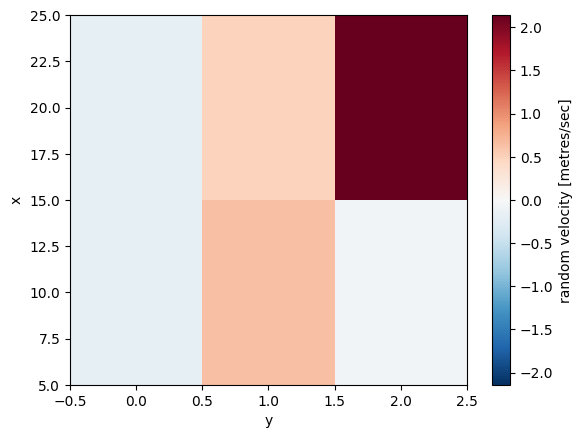

In [21]:
data.plot()

Xarray objects can be easily converted to and from pandas objects

In [22]:
series = data.to_series()
series

x   y
10  0   -0.198014
    1    0.646081
    2   -0.075661
20  0   -0.192510
    1    0.499456
    2    2.140384
dtype: float64

In [23]:
reverse = series.to_xarray()
reverse

<xarray.DataArray (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 0 1 2

## Pandas and Xarray

Xarray objects can be easily converted to and from pandas objects using the **to_series()**, **to_dataframe()** and **to_xarray()** methods

In [24]:
data

<xarray.DataArray (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

In [25]:
series = data.to_series()
series

x   y
10  0   -0.198014
    1    0.646081
    2   -0.075661
20  0   -0.192510
    1    0.499456
    2    2.140384
dtype: float64

In [27]:
data_conv = series.to_xarray()
data_conv

<xarray.DataArray (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 0 1 2

In [37]:
data_df =  data_conv.to_dataframe(name="Values")
data_df

Values
x  y          
10 0 -0.198014
   1  0.646081
   2 -0.075661
20 0 -0.192510
   1  0.499456
   2  2.140384

## Dataset

<span style="color:deepskyblue"> **xarray.Dataset**</span> is a dict-like container of aligned **DataArray** objects. You can think of it as a multi-dimensional generalization of the pandas.DataFrame:

In [29]:
ds = xr.Dataset(dict(foo=data, bar=("x", [1, 2]), baz=np.pi))
ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    foo      (x, y) float64 -0.198 0.6461 -0.07566 -0.1925 0.4995 2.14
    bar      (x) int64 1 2
    baz      float64 3.142

This creates a dataset with three DataArrays named foo, bar and baz. We can use dictionary or dot indexing to pull out Dataset variables as DataArray objects. Assignment only works with dictionary indexing,

In [30]:
ds["foo"]

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

In [31]:
ds.foo

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[-0.19801384,  0.646081  , -0.07566074],
       [-0.19251015,  0.49945609,  2.14038394]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

When creating **ds**, **foo** is two-dimensional two dimensions x and y, **bar** is one-dimensional with single dimension x and and baz is a scalar not associated with any dimension in ds. 

Variables in datasets can have different dtype and even different dimensions, but all dimensions are assumed to refer to points in the same shared coordinate system i.e. if two variables have dimension x, that dimension must be identical in both variables.

For example, when creating ds xarray automatically aligns bar with DataArray **foo**, i.e., they share the same coordinate system so that **ds.bar['x'] == ds.foo['x'] == ds['x']**. 

As the coordinates are alligned we can index **ds.bar.sel(x=10)**, even when this dimensuin has not been defined for **bar**.

In [33]:
ds.bar.sel(x=10)

<xarray.DataArray 'bar' ()>
array(1)
Coordinates:
    x        int64 10

## netCFD

The recommended way to store xarray data structures is netCDF, which is a binary file format for self-described datasets. It is mainly used in geosciences. Xarray is based on the netCDF data model, so group of netCDF files on disk directly correspond to Dataset objects in Xarray.

In [39]:
ds = xr.Dataset(
    {"foo": (("x", "y"), np.random.rand(4, 5))},
    coords={
        "x": [10, 20, 30, 40],
        "y": pd.date_range("2000-01-01", periods=5),
        "z": ("x", list("abcd")),
    },
)

ds

<xarray.Dataset>
Dimensions:  (x: 4, y: 5)
Coordinates:
  * x        (x) int64 10 20 30 40
  * y        (y) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04 2000-01-05
    z        (x) <U1 'a' 'b' 'c' 'd'
Data variables:
    foo      (x, y) float64 0.8834 0.2221 0.173 0.5538 ... 0.7119 0.433 0.7556

In [45]:
ds.to_netcdf("saved_on_disk.nc")

In [46]:
!ls

dask-worker.e94560542  dask-worker.e95589910  dask-worker.o95103739
dask-worker.e94560549  dask-worker.e95589920  dask-worker.o95103749
dask-worker.e95021613  dask-worker.e95646848  dask-worker.o95534005
dask-worker.e95021620  dask-worker.e95646849  dask-worker.o95534042
dask-worker.e95099697  dask-worker.o94560542  dask-worker.o95589910
dask-worker.e95099737  dask-worker.o94560549  dask-worker.o95589920
dask-worker.e95100293  dask-worker.o95021613  dask-worker.o95646848
dask-worker.e95100296  dask-worker.o95021620  dask-worker.o95646849
dask-worker.e95103739  dask-worker.o95099697  mydask.png
dask-worker.e95103749  dask-worker.o95099737  saved_on_disk.nc
dask-worker.e95534005  dask-worker.o95100293
dask-worker.e95534042  dask-worker.o95100296


Similarly we can also open an existing netCFD file.

In [48]:
ds_nc = xr.open_dataset("saved_on_disk.nc")
ds_nc

<xarray.Dataset>
Dimensions:  (y: 5, x: 4)
Coordinates:
  * y        (y) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04 2000-01-05
    z        (x) object ...
  * x        (x) int32 10 20 30 40
Data variables:
    foo      (x, y) float64 ...

## Xarray and Dask

In [50]:
!ls /scratch/vp91/Training-Modules/dask-xarray/data

OsloAeroSec2011-3_subset2.nc


In [4]:
%matplotlib inline

from dask.distributed import Client

For this tutorial we will use a local Dask cluster

In [16]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='5GB')
client

/scratch/vp91/Training-Venv/dask/dask-venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43897 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43897/status,
Dashboard: /proxy/43897/status,Workers: 2
Total threads: 4,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33173,Workers: 2
Dashboard: /proxy/43897/status,Total threads: 4
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:45763,Total threads: 2
Dashboard: /proxy/43961/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:39227,


In [6]:
ds = xr.open_dataset("/scratch/vp91/Training-Modules/dask-xarray/data/OsloAeroSec2011-3_subset2.nc")

In [7]:
ds

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, lev: 32, time: 36)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2011-02-01 2011-03-01 ... 2014-01-01
Data variables:
    hyam     (lev) float64 ...
    hybm     (lev) float64 ...
    P0       float64 ...
    N_AER    (time, lev, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    T        (time, lev, lat, lon) float32 ...
    U        (time, lev, lat, lon) float32 ...
    V        (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              OsloAeroSec_intBVOC_f19_f19
    logname:           x_sarbl
    host:              
    initial_file:      OsloAero_intBVOC_f19_f19_spinup.cam.i.2011-01-01-00000.nc
    topography_file:   /proj/cesm_input-data/inputdata/noresm-only/inputForNu...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Tue Nov  2 08:04:41 2021: ncrcat -v T,N_AER,V,U atm/hi...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [9]:
da = ds['hyam']
da

<xarray.DataArray 'hyam' (lev: 32)>
[32 values with dtype=float64]
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:  hybrid A coefficient at layer midpoints

In [11]:
da.persist()

<xarray.DataArray 'hyam' (lev: 32)>
[32 values with dtype=float64]
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:  hybrid A coefficient at layer midpoints

We can convert **Xarray dataset** to **Dask Dataframe**.

In [12]:
dask_df = ds.to_dask_dataframe()

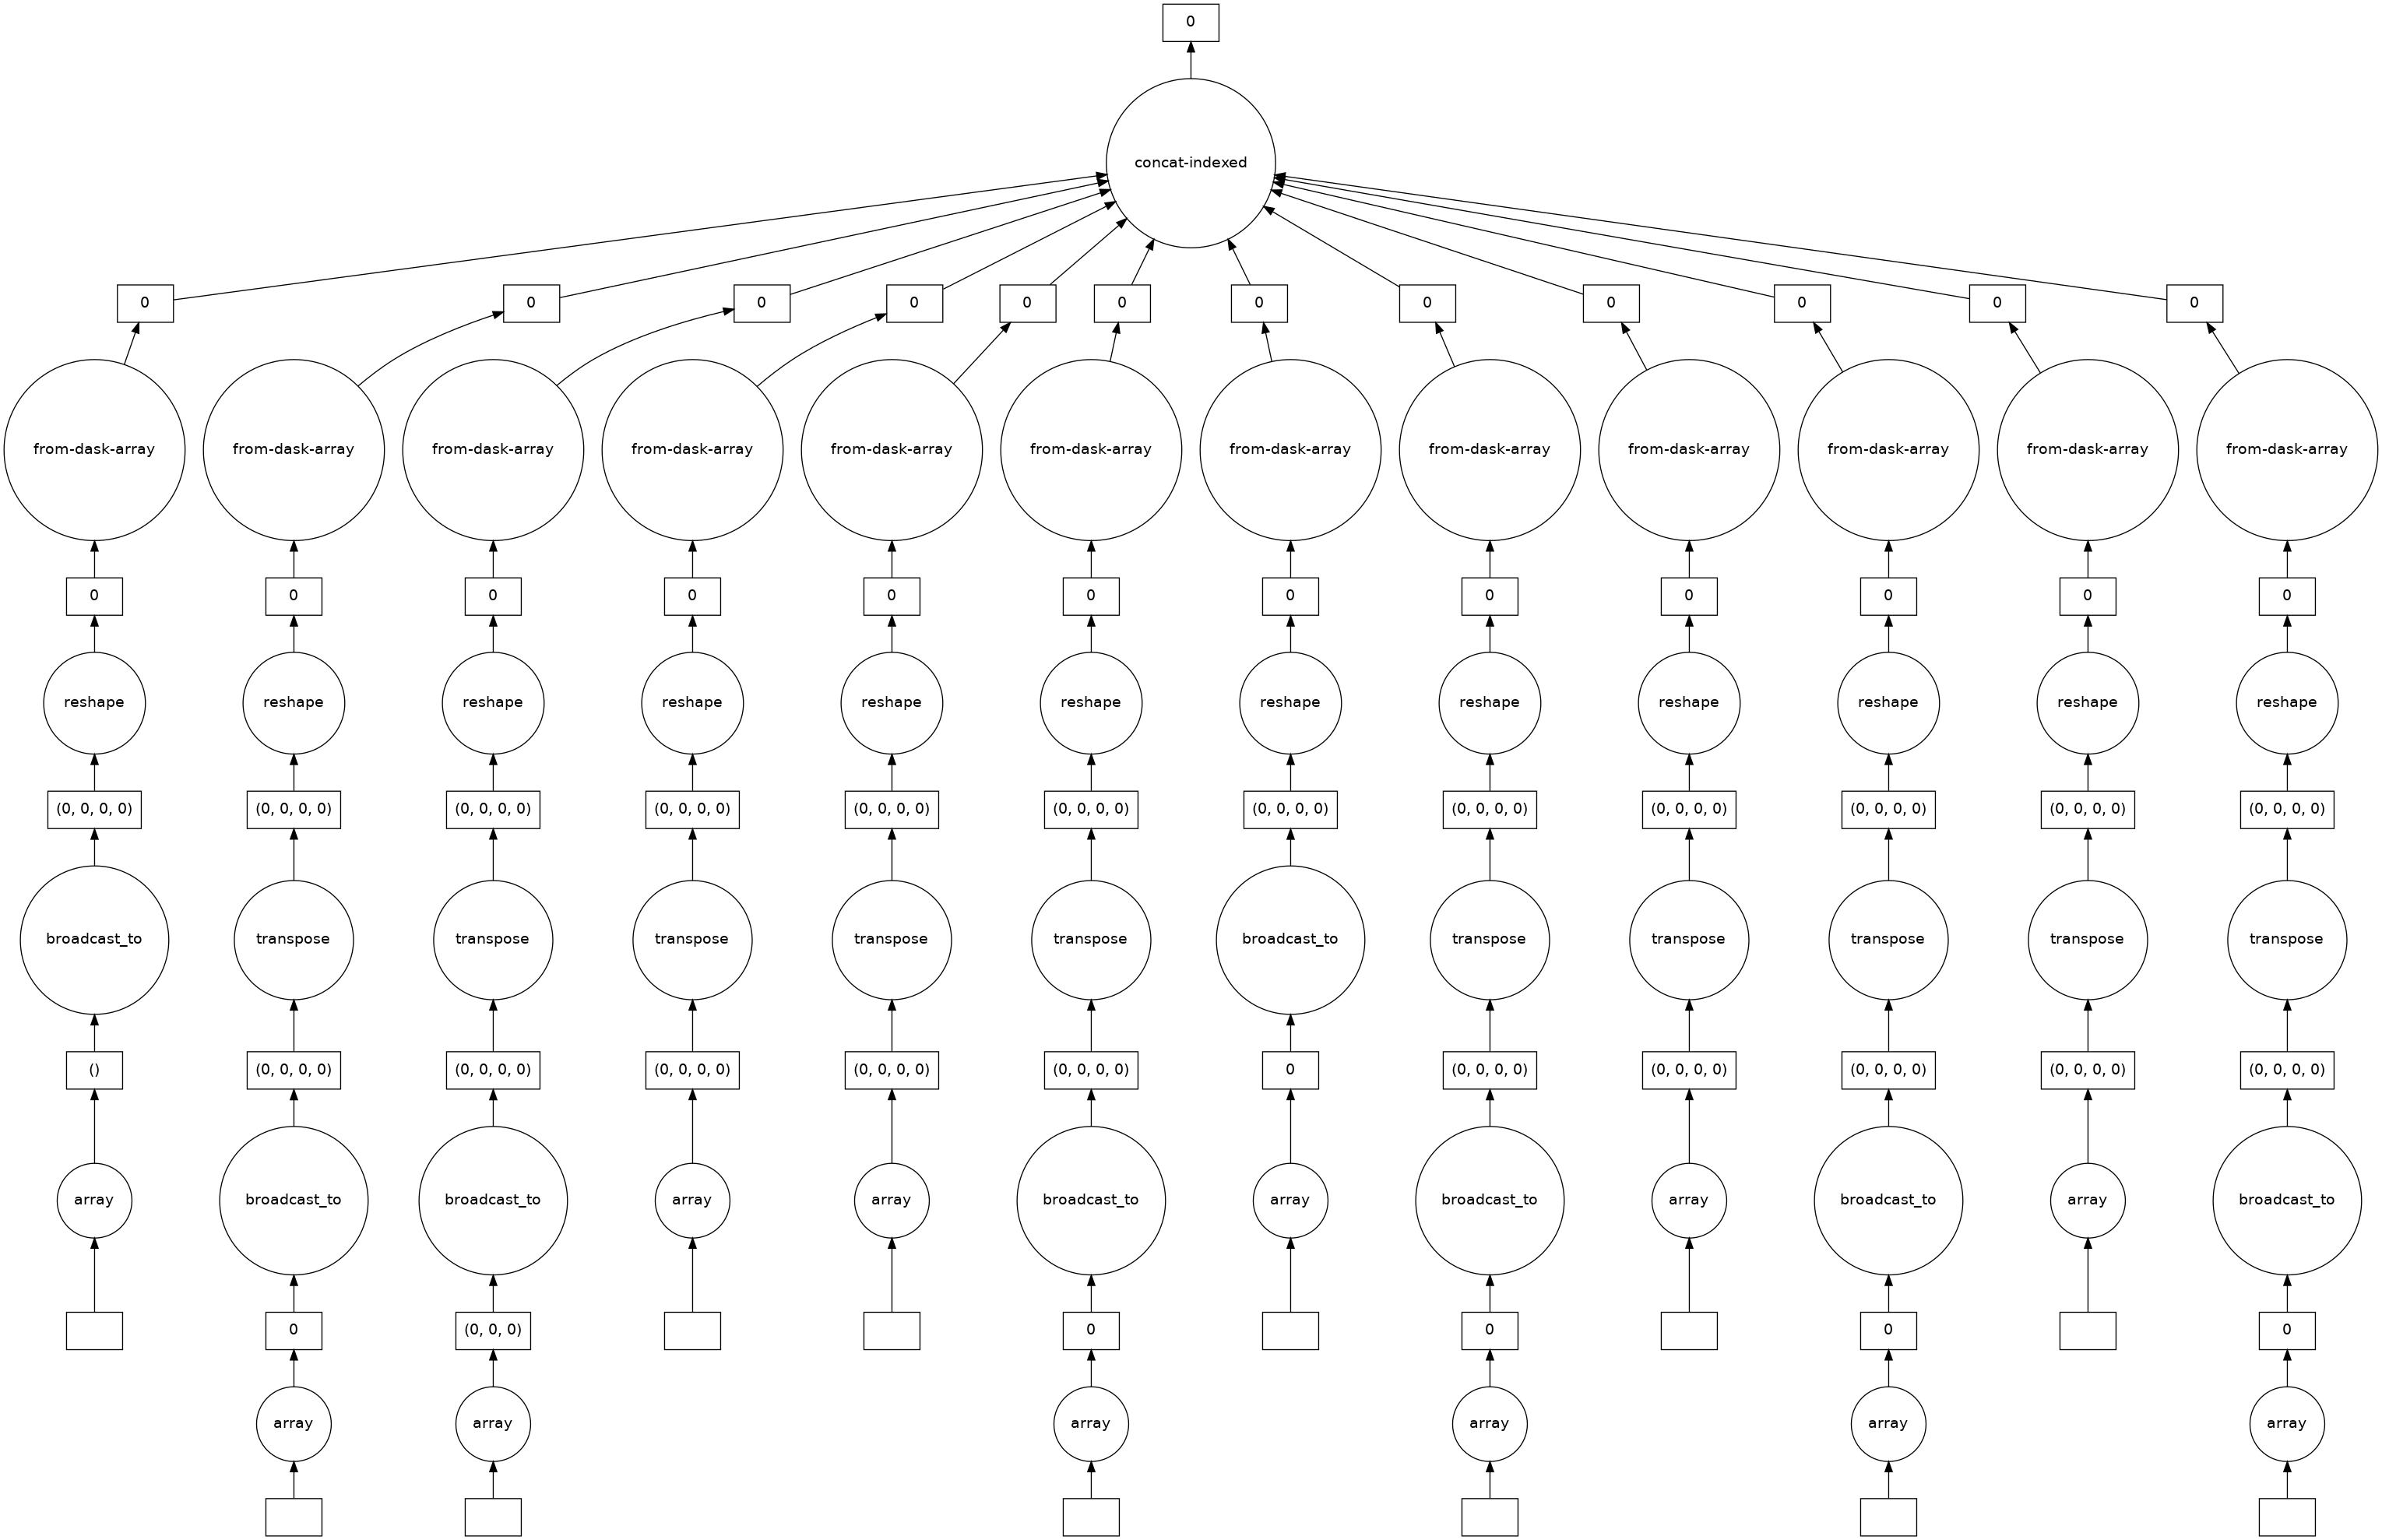

In [13]:
dask_df.visualize()

In [17]:
dask_df.head()

2023-09-27 11:25:34,651 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.81 GiB -- Worker memory limit: 4.66 GiB
2023-09-27 11:25:34,894 - distributed.worker.memory - WARNING - Worker is at 30% memory usage. Resuming worker. Process memory: 1.41 GiB -- Worker memory limit: 4.66 GiB


,lat,lon,lev,time,hyam,hybm,P0,N_AER,PS,T,U,V
0,-90.0,0.0,3.643466,2011-02-01,0.003643,0.0,100000.0,0.003109,69700.375000,268.259644,-0.124056,0.246210
1,-90.0,0.0,3.643466,2011-03-01,0.003643,0.0,100000.0,0.001479,69311.914062,254.830688,-1.023634,0.266339
2,-90.0,0.0,3.643466,2011-04-01,0.003643,0.0,100000.0,0.001086,68972.187500,234.256348,-7.849822,-2.959347
3,-90.0,0.0,3.643466,2011-05-01,0.003643,0.0,100000.0,0.000734,68879.500000,210.892990,-4.973210,-2.653848
4,-90.0,0.0,3.643466,2011-06-01,0.003643,0.0,100000.0,0.001391,68319.210938,199.873764,-4.440761,2.074858
